<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Transfer_Learning_Cats_and_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
data_file_name = "catsdogs.zip"
download_dir = '/tmp/'
urllib.request.urlretrieve(data_url,data_file_name)
zip_ref = zipfile.ZipFile(data_file_name,'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [2]:
print("Number of cat images : ",len(os.listdir('/tmp/PetImages/Cat/')))
print("Number of dog images : ",len(os.listdir("/tmp/PetImages/Dog/")))

Number of cat images :  12501
Number of dog images :  12501


In [3]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [4]:
import random
from shutil import copyfile

def split_data(SOURCE,TRAINING,TESTING,SPLIT_SIZE):
  files = []

  # Filter out the empty files
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files,len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[training_length:]

  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file,destination)

  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file,destination)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = 0.9
split_data(CAT_SOURCE_DIR,TRAINING_CATS_DIR,TESTING_CATS_DIR,split_size)
split_data(DOG_SOURCE_DIR,TRAINING_DOGS_DIR,TESTING_DOGS_DIR,split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [5]:
print("Number of training cat images : " ,len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print("Number of training dog images : " ,len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print("Number of testing cat images : " ,len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print("Number of testing dog images : " ,len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))

Number of training cat images :  11250
Number of training dog images :  11250
Number of testing cat images :  1250
Number of testing dog images :  1250


In [6]:
TRAINING_DIR = '/tmp/cats-v-dogs/training/'

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size = 100,
    class_mode = 'binary',
    target_size = (150,150)
)


VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size = 100,
    class_mode = 'binary',
    target_size = (150,150)
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [7]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url,weights_file)

# Instantiate the model
pre_trained_model = InceptionV3(
    input_shape = (150,150,3),
    include_top = False,
    weights = None
)

# Load pre-trained weights
pre_trained_model.load_weights(weights_file)

# Freeze the layers
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print("Last layer output shape : ", last_layer.output_shape)
last_output = last_layer.output

Last layer output shape :  (None, 7, 7, 768)


In [8]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation = 'relu')(x)
x = layers.Dense(1,activation = 'sigmoid')(x)

model = Model(pre_trained_model.input,x)

In [9]:
# Compile the model
model.compile(
    optimizer = RMSprop(lr = 0.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 10,
    verbose = 1
)

Epoch 1/10
214/225 [===========================>..] - ETA: 7s - loss: 0.5556 - accuracy: 0.8935

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 [==============================] - 168s 709ms/step - loss: 0.5370 - accuracy: 0.8948 - val_loss: 0.1025 - val_accuracy: 0.9552
Epoch 2/10
225/225 [==============================] - 155s 690ms/step - loss: 0.1499 - accuracy: 0.9375 - val_loss: 0.0834 - val_accuracy: 0.9624
Epoch 3/10
225/225 [==============================] - 156s 692ms/step - loss: 0.1360 - accuracy: 0.9431 - val_loss: 0.0923 - val_accuracy: 0.9612
Epoch 4/10
225/225 [==============================] - 157s 698ms/step - loss: 0.1244 - accuracy: 0.9476 - val_loss: 0.0917 - val_accuracy: 0.9636
Epoch 5/10
225/225 [==============================] - 156s 694ms/step - loss: 0.1239 - accuracy: 0.9488 - val_loss: 0.0738 - val_accuracy: 0.9688
Epoch 6/10
225/225 [==============================] - 155s 687ms/step - loss: 0.1202 - accuracy: 0.9498 - val_loss: 0.0666 - val_accuracy: 0.9740
Epoch 7/10
225/225 [==============================] - 157s 696ms/step - loss: 0.1192 - accuracy: 0.9513 - val_loss: 0.0713 - val_accura

<Figure size 640x480 with 0 Axes>

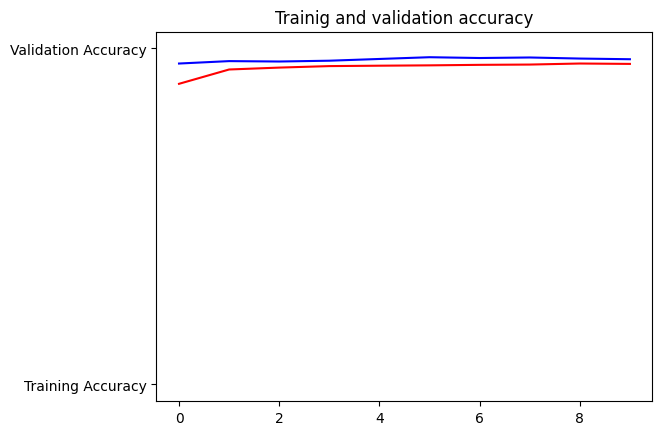

<Figure size 640x480 with 0 Axes>

In [15]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc =history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',"Training Accuracy")
plt.plot(epochs,val_acc,'b','Validation Accuracy')
plt.title("Trainig and validation accuracy")
plt.figure()